# Results of IIA-GCL and IIA-TCL experiments

This notebook presents the numerical results obtained with the **IIA-GCL** and **IIA-TCL** algorithms.

We consider two types of datasets:
- **Simulated data**, for which the ground-truth latent innovations are known and can be directly compared to the estimated components.
- **Financial data**, where the methods areR applied to real-world time series in order to analyze and interpret the extracted latent structures.

The notebook is organized to first report results on simulated data, including quantitative metrics and visual diagnostics, and then to present the corresponding analyses on financial datasets.Simulated Data:

## Simulated data
### IIA-GCL

Generating mlp parameters...
    cond thresh: 17.055634
    L0: cond=68.789569
    L0: cond=23.433151
    L0: cond=11.984876
    L0s: cond=23.196500
    L0s: cond=13.882289
    L1: cond=238.741581
    L1: cond=43.816264
    L1: cond=456.809691
    L1: cond=22.566767
    L1: cond=22.610590
    L1: cond=38.827999
    L1: cond=11.968617
Generating source...
PCA...
    num_comp=10
    use learned value
h_val shape: (32767, 10)
s shape: (10, 32768)
h_val shape: (32767, 10)
s_for_corr shape: (32767, 10)
Calculating correlation...

Correlation matrix (diagonal = optimal alignment):
[[-0.961  0.048  0.016 -0.064 -0.056 -0.02  -0.015  0.053  0.02   0.032]
 [ 0.037 -0.973 -0.061 -0.004 -0.02  -0.068 -0.039 -0.063  0.006  0.017]
 [-0.039 -0.008  0.974 -0.034  0.017  0.071 -0.013  0.076  0.012 -0.026]
 [ 0.06   0.024 -0.015  0.983 -0.04  -0.005 -0.028 -0.011  0.048 -0.056]
 [ 0.052 -0.006  0.009 -0.045  0.957 -0.019 -0.075 -0.021  0.024 -0.058]
 [ 0.011 -0.028 -0.042  0.017  0.048 -0.944  0.002  0

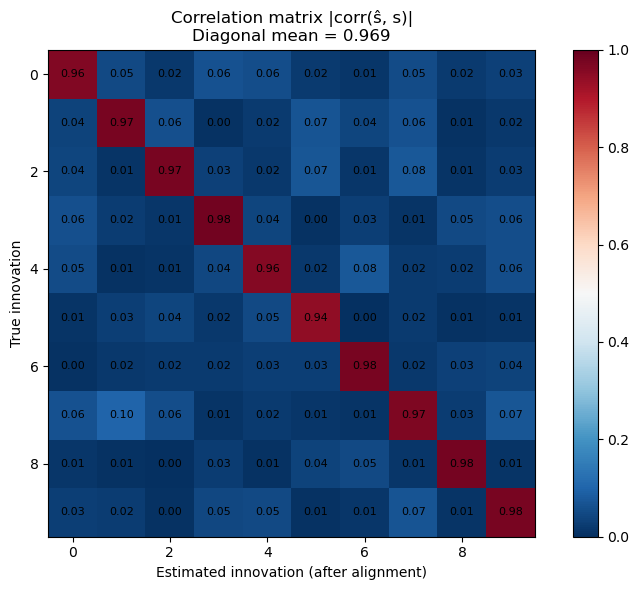

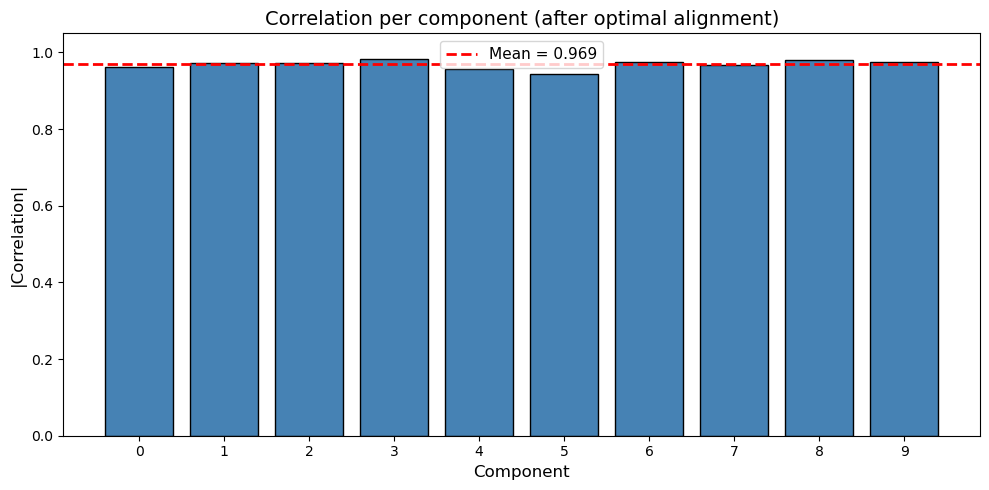

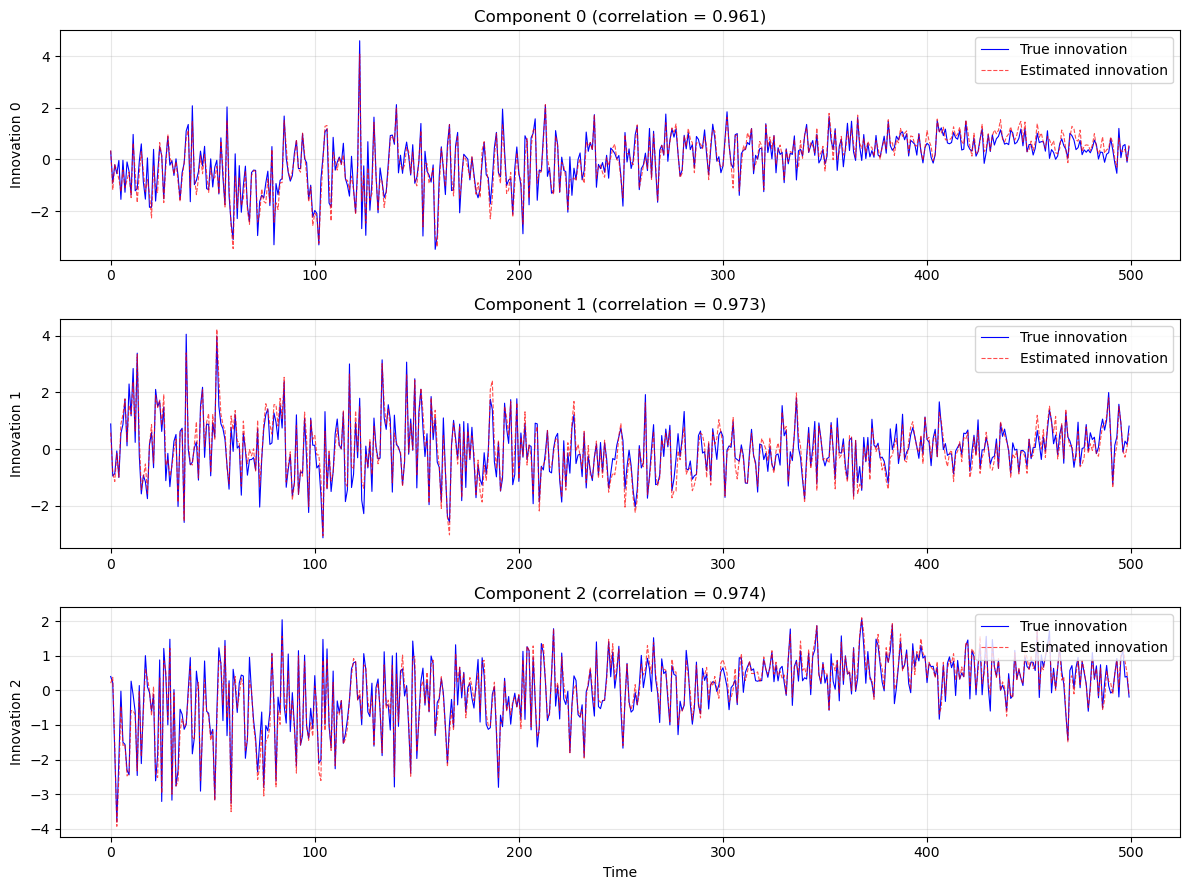


RESULTS SUMMARY
Dimension: 10
Number of data points: 32768
Mean correlation: 0.9692
Min correlation: 0.9444
Max correlation: 0.9833
Standard deviation: 0.0112


In [1]:
"""
Analysis of IIA-GCL results on simulated data
"""
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch

from subfunc.generate_artificial_data import generate_artificial_data
from subfunc.preprocessing import pca
from igcl import igcl, utils

# ============================================================
# Load parameters and model
# ============================================================

eval_dir = './storage/model_20251230_012619'
parmpath = os.path.join(eval_dir, 'parm.pkl')
modelpath = os.path.join(eval_dir, 'model.pt')

with open(parmpath, 'rb') as f:
    model_parm = pickle.load(f)

num_comp = model_parm['num_comp']
num_data = model_parm['num_data']
ar_order = model_parm['ar_order']
num_basis = model_parm['num_basis']
list_hidden_nodes = model_parm['list_hidden_nodes']
list_hidden_nodes_z = model_parm.get('list_hidden_nodes_z')
random_seed = model_parm['random_seed']
pca_parm = model_parm['pca_parm']

# ============================================================
# Regenerate the same data
# ============================================================

x, s, y, _, _, _, _, _, _ = generate_artificial_data(
    num_comp=num_comp,
    num_data=num_data,
    num_layer=model_parm['num_layer'],
    num_basis=num_basis,
    modulate_range1=model_parm['modulate_range'],
    modulate_range2=model_parm['modulate_range2'],
    random_seed=random_seed
)

x, _ = pca(x, num_comp=num_comp, params=pca_parm)
x = x.T  # (num_data, num_comp)

# ============================================================
# Load Model
# ============================================================

if list_hidden_nodes_z is None:
    list_hidden_nodes_z = list_hidden_nodes.copy()

model = igcl.NetGaussScaleMean(
    h_sizes=list_hidden_nodes,
    h_sizes_z=list_hidden_nodes_z,
    ar_order=ar_order,
    num_dim=x.shape[1],
    num_data=num_data,
    num_basis=num_basis
)

checkpoint = torch.load(modelpath, map_location='cpu')
model.load_state_dict(checkpoint['ema_state_dict'])
model.eval()

# ============================================================
# Prepare AR Data
# ============================================================

t_idx = np.arange(x.shape[0] - ar_order) + ar_order
t_idx = t_idx.reshape([-1, 1]) + np.arange(0, -ar_order - 1, -1).reshape([1, -1])
x_ar = x[t_idx.reshape(-1), :].reshape([-1, ar_order + 1, x.shape[-1]])
y_ar = y[t_idx[:, 0]]

# Forward pass
x_torch = torch.from_numpy(x_ar.astype(np.float32))
y_torch = torch.from_numpy(y_ar).type(torch.LongTensor)

with torch.no_grad():
    logits, h, hz, _, _ = model(x_torch, y_torch)
    # Split to retrieve only true predictions (not shuffled ones)
    h, h_star = torch.split(h, split_size_or_sections=int(h.size()[0]//2), dim=0)

h_val = np.squeeze(h.numpy())

print(f"h_val shape: {h_val.shape}")
print(f"s shape: {s.shape}")

# ============================================================
# Compute Correlation
# ============================================================
s_for_corr = s[:, :-1].T  # (num_data-1, num_comp)

print(f"h_val shape: {h_val.shape}")
print(f"s_for_corr shape: {s_for_corr.shape}")

corrmat, sort_idx, h_sorted = utils.correlation(h_val, s_for_corr, 'Pearson')

print("\nCorrelation matrix (diagonal = optimal alignment):")
print(np.round(corrmat, 3))

mean_corr = np.mean(np.abs(np.diag(corrmat)))
print(f"\nMean correlation: {mean_corr:.4f}")


# ============================================================
# Figures
# ============================================================

# Figure 1: Correlation Matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(np.abs(corrmat), cmap='RdBu_r', vmin=0, vmax=1)
ax.set_xlabel('Estimated innovation (after alignment)')
ax.set_ylabel('True innovation')
ax.set_title(f'Correlation matrix |corr(ŝ, s)|\nDiagonal mean = {mean_corr:.3f}')
plt.colorbar(im, ax=ax)

for i in range(num_comp):
    for j in range(num_comp):
        ax.text(j, i, f'{np.abs(corrmat[i,j]):.2f}', ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Figure 2: Correlation per Component
diag_corr = np.abs(np.diag(corrmat))

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(range(num_comp), diag_corr, color='steelblue', edgecolor='black')
ax.axhline(y=mean_corr, color='red', linestyle='--', linewidth=2, 
           label=f'Mean = {mean_corr:.3f}')
ax.set_xlabel('Component', fontsize=12)
ax.set_ylabel('|Correlation|', fontsize=12)
ax.set_title('Correlation per component (after optimal alignment)', fontsize=14)
ax.set_ylim([0, 1.05])
ax.legend(fontsize=11)
ax.set_xticks(range(num_comp))

plt.tight_layout()
plt.show()

# Figure 3: Temporal Comparison
n_show = 3
t_range = np.arange(500)

fig, axes = plt.subplots(n_show, 1, figsize=(12, 3*n_show))

s_aligned = s[:, :-1]  # (num_comp, num_data-1)

for i in range(n_show):
    corr_val = corrmat[i, i]
    
    s_i = s_aligned[i, t_range]
    h_i = h_sorted[i, t_range]
    
    # Normalize
    s_norm = (s_i - np.mean(s_i)) / np.std(s_i)
    h_norm = (h_i - np.mean(h_i)) / np.std(h_i)
    
    # Adjust sign if correlation is negative
    if corr_val < 0:
        h_norm = -h_norm
    
    axes[i].plot(t_range, s_norm, 'b-', linewidth=0.8, label='True innovation')
    axes[i].plot(t_range, h_norm, 'r--', linewidth=0.8, alpha=0.7, label='Estimated innovation')
    axes[i].set_ylabel(f'Innovation {i}')
    axes[i].set_title(f'Component {i} (correlation = {np.abs(corr_val):.3f})')
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

# Summary

print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)
print(f"Dimension: {num_comp}")
print(f"Number of data points: {num_data}")
print(f"Mean correlation: {mean_corr:.4f}")
print(f"Min correlation: {np.min(diag_corr):.4f}")
print(f"Max correlation: {np.max(diag_corr):.4f}")
print(f"Standard deviation: {np.std(diag_corr):.4f}")
print("="*50)

### IIA-TCL

Generating mlp parameters...
    cond thresh: 17.055634
    L0: cond=68.789569
    L0: cond=23.433151
    L0: cond=11.984876
    L0s: cond=23.196500
    L0s: cond=13.882289
    L1: cond=238.741581
    L1: cond=43.816264
    L1: cond=456.809691
    L1: cond=22.566767
    L1: cond=22.610590
    L1: cond=38.827999
    L1: cond=11.968617
Generating source...
Generating source...
PCA...
    num_comp=10
    contribution ratio=1.000000
PCA...
    num_comp=10
    use learned value
2026-01-07 00:14:22.287408: step 0, lr = 0.100000, loss = 5.67, accuracy = 0.00 (2097.6 examples/sec; 0.122 sec/batch)
2026-01-07 00:14:22.972043: step 100, lr = 0.100000, loss = 4.97, accuracy = 5.08 (60312.4 examples/sec; 0.004 sec/batch)
2026-01-07 00:14:23.483170: step 200, lr = 0.100000, loss = 4.73, accuracy = 5.08 (31705.6 examples/sec; 0.008 sec/batch)
2026-01-07 00:14:23.988497: step 300, lr = 0.100000, loss = 4.52, accuracy = 7.03 (31575.1 examples/sec; 0.008 sec/batch)
2026-01-07 00:14:24.492095: step 400,

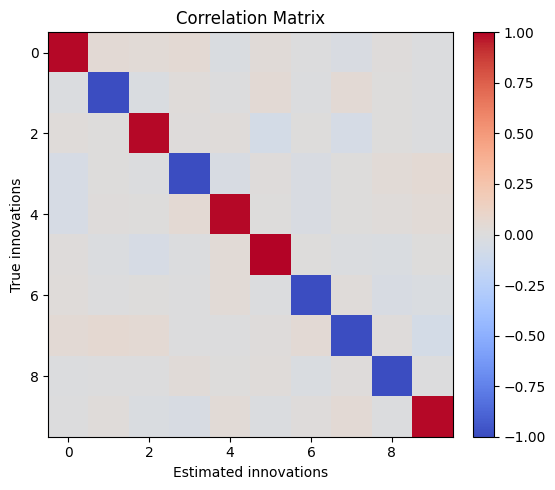

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from subfunc.generate_artificial_data import generate_artificial_data
from subfunc.preprocessing import pca
from igcl.igcl_train import train as igcl_train
from itcl.itcl_train import train as itcl_train
from igcl import igcl, utils
from itcl import itcl
from sklearn.metrics import accuracy_score
from subfunc.showdata import *

# Parameters
num_layer = 2
num_comp = 10
num_data = 2**15
num_basis = 64
modulate_range = [-2, 2]
modulate_range2 = [-2, 2]
ar_order = 1
random_seed = 0
net_model, num_segment = 'itcl', 256      # we can choose here the model and the number of segments
list_hidden_nodes = [4 * num_comp] * (num_layer - 1) + [num_comp]
list_hidden_nodes_z = None

initial_learning_rate = 0.1
momentum = 0.9
max_steps = 80_000
decay_steps = int(1e6)
decay_factor = 0.1
batch_size = 256
moving_average_decay = 0.999
checkpoint_steps = 20_000
summary_steps = 2_000
weight_decay = 1e-5
train_dir = './storage/temp_model'

# Data generation (Train & Test)
x, s, y, x_te, s_te, y_te, _, _, _ = generate_artificial_data(
    num_comp=num_comp, num_data=num_data, num_layer=num_layer,
    num_basis=num_basis, modulate_range1=modulate_range,
    modulate_range2=modulate_range2, num_data_test=num_data, random_seed=random_seed)

if net_model == 'itcl':
    y = np.tile(np.arange(num_segment), [int(np.ceil(num_data / num_segment)), 1]).T.reshape(-1)[:num_data]
    y_te = np.tile(np.arange(num_segment), [int(np.ceil(num_data / num_segment)), 1]).T.reshape(-1)[:num_data]

# Preprocessing
x, pca_parm = pca(x, num_comp=num_comp)
x_te, _ = pca(x_te, num_comp, params=pca_parm)

# Training
train_args = {
    'list_hidden_nodes': list_hidden_nodes, 'list_hidden_nodes_z': list_hidden_nodes_z,
    'initial_learning_rate': initial_learning_rate, 'momentum': momentum,
    'max_steps': max_steps, 'decay_steps': decay_steps, 'decay_factor': decay_factor,
    'batch_size': batch_size, 'train_dir': train_dir, 'ar_order': ar_order,
    'weight_decay': weight_decay, 'checkpoint_steps': checkpoint_steps,
    'moving_average_decay': moving_average_decay, 'summary_steps': summary_steps,
    'random_seed': random_seed
}

if net_model == 'igcl':
    igcl_train(x.T, y, num_data=num_data, num_basis=num_basis, **train_args)
    model = igcl.NetGaussScaleMean(h_sizes=list_hidden_nodes, h_sizes_z=list_hidden_nodes_z,
                                   ar_order=ar_order, num_dim=num_comp, num_data=num_data, num_basis=num_basis)
else:
    itcl_train(x.T, y, num_segment=num_segment, **train_args)
    model = itcl.Net(h_sizes=list_hidden_nodes, h_sizes_z=list_hidden_nodes_z,
                     ar_order=ar_order, num_dim=num_comp, num_class=num_segment)

# Evaluation
device = 'cpu'
modelpath = os.path.join(train_dir, 'model.pt')
checkpoint = torch.load(modelpath, map_location=device)
model.load_state_dict(checkpoint['ema_state_dict'] if 'ema_state_dict' in checkpoint else checkpoint['model_state_dict'])
model.to(device).eval()

def prepare_data(data_x, data_y):
    t_idx = np.arange(data_x.shape[0] - ar_order) + ar_order
    t_idx = t_idx.reshape([-1, 1]) + np.arange(0, -ar_order - 1, -1).reshape([1, -1])
    new_x = data_x[t_idx.reshape(-1), :].reshape([-1, ar_order + 1, data_x.shape[-1]])
    return torch.from_numpy(new_x.astype(np.float32)).to(device), data_y[t_idx[:, 0]]

x_torch, y_eval = prepare_data(x.T, y)
x_te_torch, y_te_eval = prepare_data(x_te.T, y_te)

with torch.no_grad():
    if net_model == 'igcl':
        logits, h, _, _, _ = model(x_torch, torch.from_numpy(y_eval).type(torch.LongTensor).to(device))
        pred = (logits > 0.5).float().cpu().numpy()
        label = np.concatenate([np.ones(y_eval.shape[0]), np.zeros(y_eval.shape[0])])
        accu_tr = accuracy_score(pred, label)
        
        logits_te, _, _, _, _ = model(x_te_torch, torch.from_numpy(y_te_eval).type(torch.LongTensor).to(device))
        accu_te = accuracy_score((logits_te > 0.5).float().cpu().numpy(), label)
        h, _ = torch.split(h, split_size_or_sections=int(h.size()[0]/2), dim=0)
    else:
        logits, h, _ = model(x_torch)
        accu_tr = accuracy_score(torch.max(logits, 1)[1].cpu().numpy(), y_eval)
        logits_te, _, _ = model(x_te_torch)
        accu_te = accuracy_score(torch.max(logits_te, 1)[1].cpu().numpy(), y_te_eval)

h_val = np.squeeze(h.cpu().numpy())
corrmat_tr, sort_idx, _ = utils.correlation(h_val, s[:, :-1].T, 'Pearson')
meanabscorr_tr = np.mean(np.abs(np.diag(corrmat_tr)))

print(f'Accuracy Train: {accu_tr*100:.2f}% | Test: {accu_te*100:.2f}% | Corr: {meanabscorr_tr:.4f}')

# Plot
plt.figure(figsize=(6, 5))
plt.imshow(corrmat_tr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel("Estimated innovations")
plt.ylabel("True innovations")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Results on Financial Data


### IIA-GCL
This section reports the results of the **IIA-GCL** algorithm applied to **financial time series**.
Unlike simulated experiments, the latent innovations are not directly observable on real data. Therefore, the analysis focuses on:

- basic diagnostics of the estimated innovations (distribution, correlation structure, temporal behaviour),
- qualitative assessment of the extracted components,
- reproducibility using saved outputs (no retraining).

All results below are obtained by loading the saved model outputs and evaluation indices.

In [2]:
data_dir = "model-igcl"

innovations_hat = np.load(f"{data_dir}/innovations_hat.npy")  # typically (T, d) or (N, d)
innovations_hz  = np.load(f"{data_dir}/innovations_hz.npy")
time_indices    = np.load(f"{data_dir}/time_indices.npy")

with open(f"{data_dir}/parm.pkl", "rb") as f:
    model_parm = pickle.load(f)

checkpoint = torch.load(f"{data_dir}/model.pt", map_location="cpu")

print("Loaded finance IIA-GCL artifacts:")
print(f"innovations_hat shape: {innovations_hat.shape}")
print(f"innovations_hz shape:  {innovations_hz.shape}")
print(f"time_indices shape:    {time_indices.shape}")
print("\nSaved hyperparameters keys:", list(model_parm.keys())[:12], "...")


Loaded finance IIA-GCL artifacts:
innovations_hat shape: (1490, 3)
innovations_hz shape:  (1490, 3)
time_indices shape:    (1490,)

Saved hyperparameters keys: ['random_seed', 'num_comp', 'num_data', 'ar_order', 'num_basis', 'num_layer', 'list_hidden_nodes', 'list_hidden_nodes_z', 'moving_average_decay', 'net_model'] ...


In [3]:
H = innovations_hat
d = H.shape[1] if H.ndim == 2 else 1

# Summary stats
mean_per_comp = H.mean(axis=0)
std_per_comp  = H.std(axis=0)

print("Per-component summary (mean ± std):")
for j in range(d):
    print(f"  comp {j:02d}: {mean_per_comp[j]: .4f} ± {std_per_comp[j]: .4f}")

# Cross-correlation matrix across components
corr_H = np.corrcoef(H.T) if H.ndim == 2 else np.array([[1.0]])
offdiag = corr_H - np.diag(np.diag(corr_H))

print("\nMean absolute off-diagonal correlation:",
      np.mean(np.abs(offdiag)))


Per-component summary (mean ± std):
  comp 00:  0.0393 ±  2.0049
  comp 01:  0.7019 ±  1.6195
  comp 02: -0.2399 ±  1.4951

Mean absolute off-diagonal correlation: 0.07955160197965999


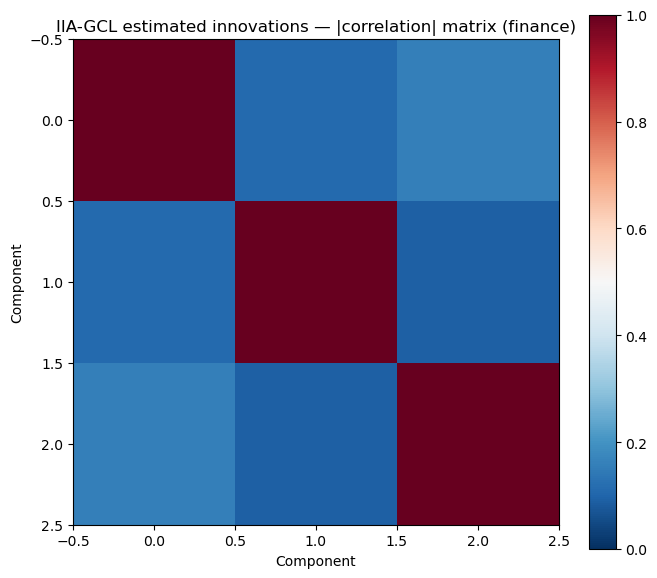

In [11]:
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(np.abs(corr_H), vmin=0, vmax=1, cmap="RdBu_r")

ax.set_title("IIA-GCL estimated innovations — |correlation| matrix (finance)")
ax.set_xlabel("Component")
ax.set_ylabel("Component")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

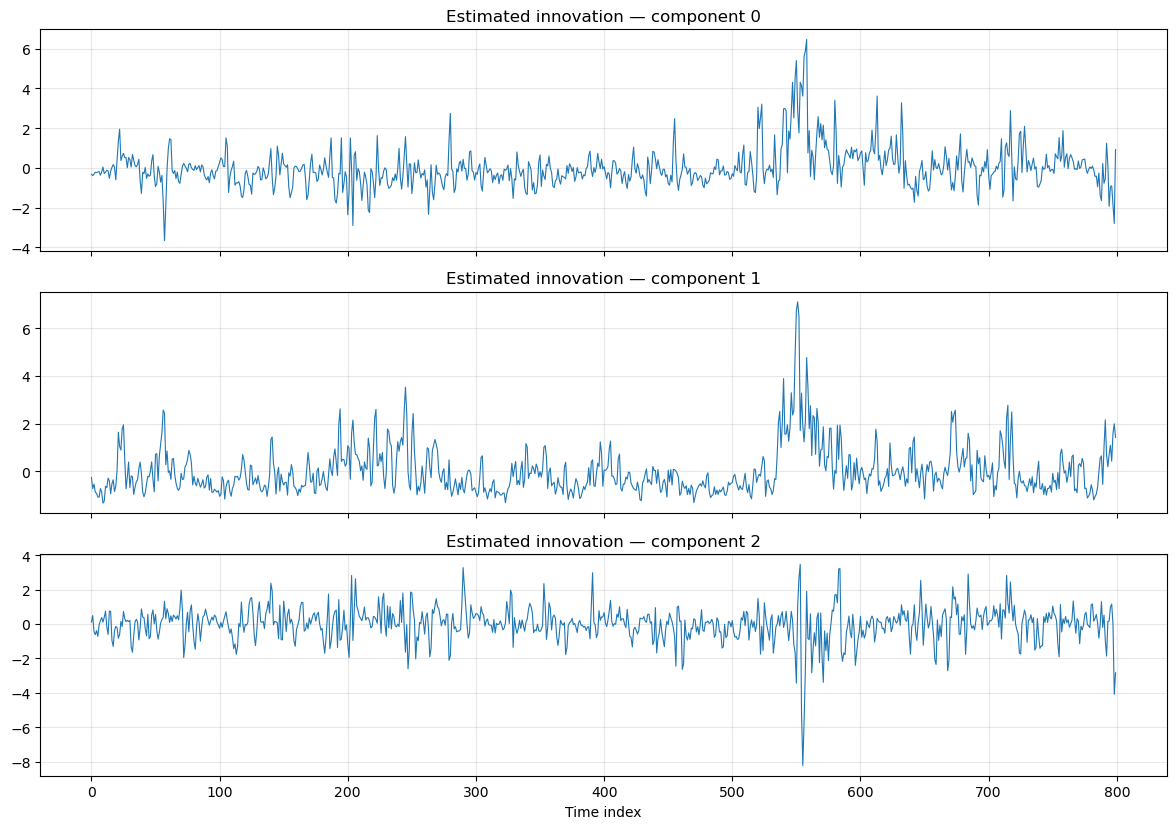

In [12]:
H = innovations_hat
T = H.shape[0]
t = np.arange(T)

n_show = min(4, H.shape[1])
t_max = min(800, T)

fig, axes = plt.subplots(n_show, 1, figsize=(12, 2.8*n_show), sharex=True)

for i in range(n_show):
    h = H[:t_max, i]
    h = (h - h.mean()) / (h.std() + 1e-12)  # normalize
    axes[i].plot(t[:t_max], h, lw=0.8)
    axes[i].set_title(f"Estimated innovation — component {i}")
    axes[i].grid(alpha=0.3)

axes[-1].set_xlabel("Time index")
plt.tight_layout()
plt.show()

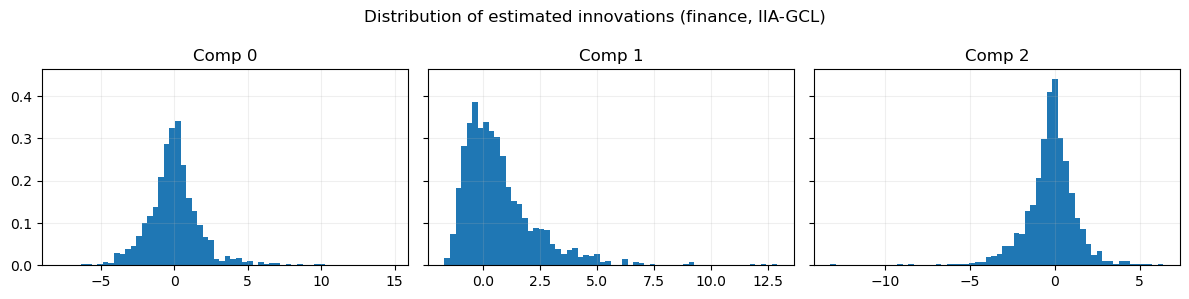

In [10]:
H = innovations_hat
n_show = min(4, H.shape[1])

fig, axes = plt.subplots(1, n_show, figsize=(4*n_show, 3), sharey=True)

for i in range(n_show):
    ax = axes[i] if n_show > 1 else axes
    ax.hist(H[:, i], bins=60, density=True)
    ax.set_title(f"Comp {i}")
    ax.grid(alpha=0.2)

plt.suptitle("Distribution of estimated innovations (finance, IIA-GCL)")
plt.tight_layout()
plt.show()


### Remarks

On financial data, the absence of ground-truth latent innovations requires a diagnostic-based evaluation.
The correlation structure, temporal stability and distributional properties of the estimated innovations provide a first level of validation for the IIA-GCL decomposition.
In the next section, similar diagnostics will be reported for IIA-TCL.


### IIA-TCL

In [7]:
import pickle

data_dir = "storage/model-itcl"

innovations_hat = np.load(f"{data_dir}/innovations_hat.npy")  
segments = np.load(f"{data_dir}/segments.npy")

with open(f"{data_dir}/parm.pkl", "rb") as f:
    model_parm = pickle.load(f)

checkpoint = torch.load(f"{data_dir}/model.pt", map_location="cpu")

print("Loaded finance IIA-GCL artifacts:")
print(f"innovations_hat shape: {innovations_hat.shape}")
print(f"segments shape:        {segments.shape}")
print("\nSaved hyperparameters keys:", list(model_parm.keys())[:12], "...")


Loaded finance IIA-GCL artifacts:
innovations_hat shape: (1280, 5)
segments shape:        (1280,)

Saved hyperparameters keys: ['random_seed', 'num_comp', 'num_data', 'ar_order', 'num_basis', 'modulate_range', 'modulate_range2', 'num_layer', 'list_hidden_nodes', 'list_hidden_nodes_z', 'moving_average_decay', 'num_segment'] ...


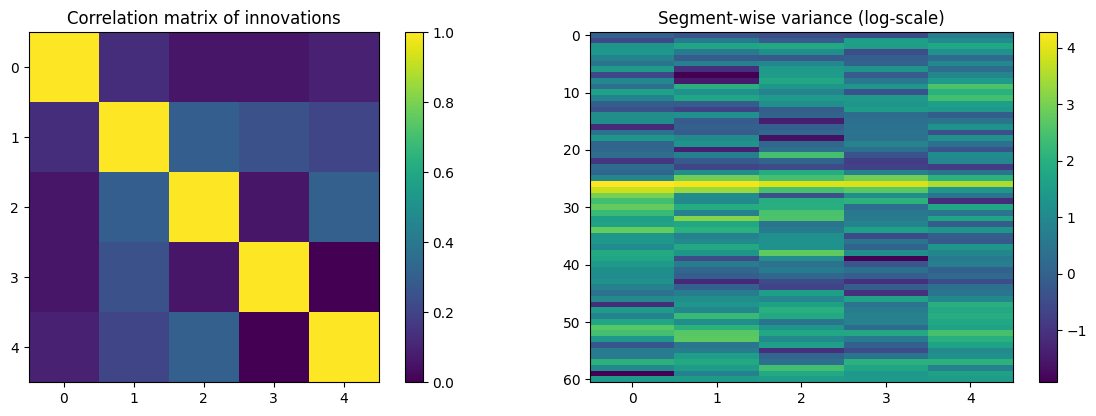

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statistical Calculation
def get_stats(h, seg):
    comps = [f"comp_{i}" for i in range(h.shape[1])]
    df = pd.DataFrame(h, columns=comps)
    df["segment"] = seg
    
    var_df = df.groupby("segment")[comps].var(ddof=1)
    
    # Non-stationarity scores (CV)
    v = var_df.values
    cv_var = np.nanstd(v, axis=0) / (np.nanmean(v, axis=0) + 1e-12)
    
    scores = pd.DataFrame({
        "component_idx": range(h.shape[1]),
        "component": comps,
        "cv_var": cv_var
    }).sort_values("cv_var", ascending=False)
    
    return var_df, scores

# Comprehensive Visualization
def plot_full_analysis(h, var_df, scores, n_series=3):
    # Setup figure with two rows: Heatmaps on top, Time Series on bottom
    fig = plt.figure(figsize=(15, 10))
    
    # --- Row 1: Heatmaps ---
    # Correlation Matrix (Matching your uploaded 'viridis' colors)
    ax1 = fig.add_subplot(2, 2, 1)
    corr = np.corrcoef(h, rowvar=False)
    im1 = ax1.imshow(corr, cmap='viridis', vmin=0, vmax=1)
    ax1.set_title("Correlation matrix of innovations")
    plt.colorbar(im1, ax=ax1)

    # Segment Variance Heatmap
    ax2 = fig.add_subplot(2, 2, 2)
    im2 = ax2.imshow(np.log(var_df.values + 1e-12), aspect='auto', cmap='viridis')
    ax2.set_title("Segment-wise variance (log-scale)")
    plt.colorbar(im2, ax=ax2)


# --- Execution ---
n_samples = min(innovations_hat.shape[0], segments.shape[0])
h_clean = innovations_hat[:n_samples]
seg_clean = segments[:n_samples]

var_stats, nonstat_scores = get_stats(h_clean, seg_clean)
plot_full_analysis(h_clean, var_stats, nonstat_scores)

Displaying the first 5 innovation time series...


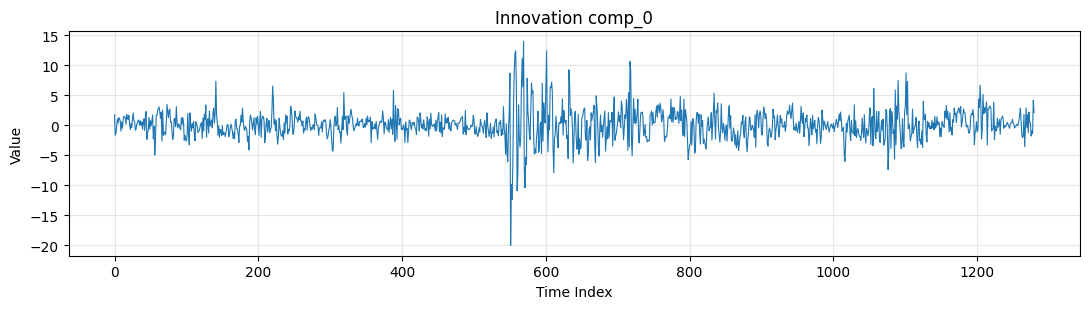

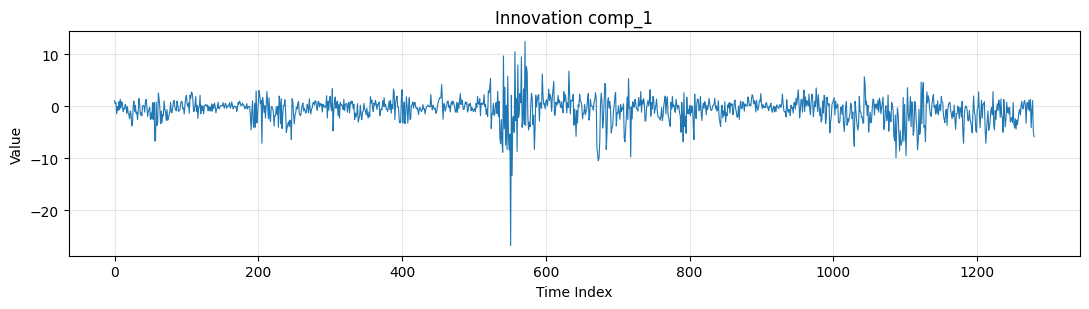

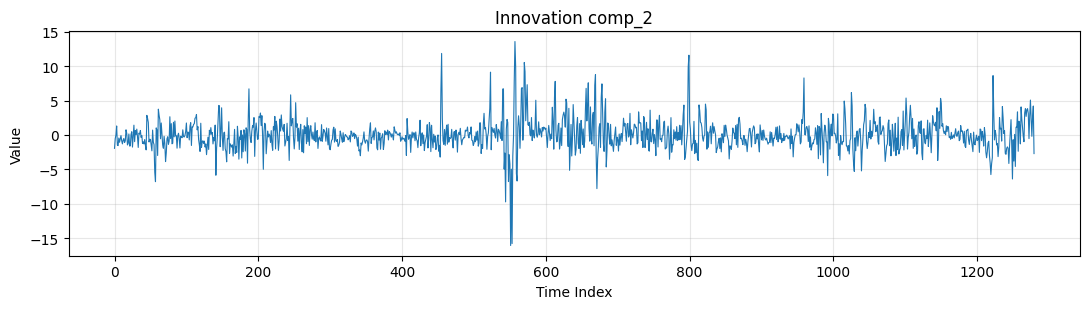

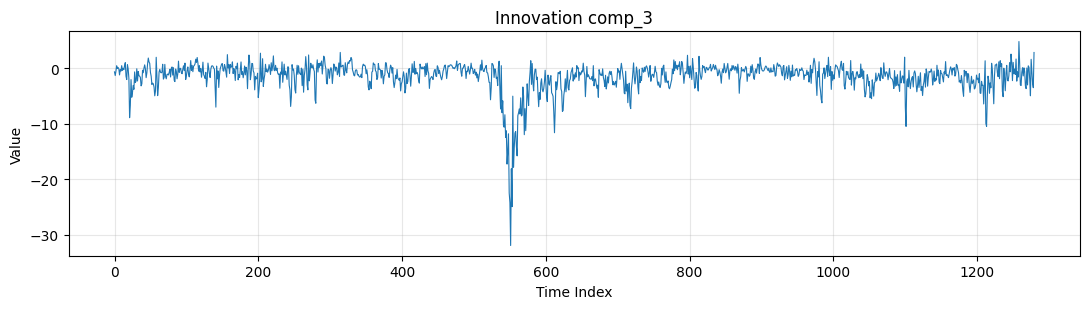

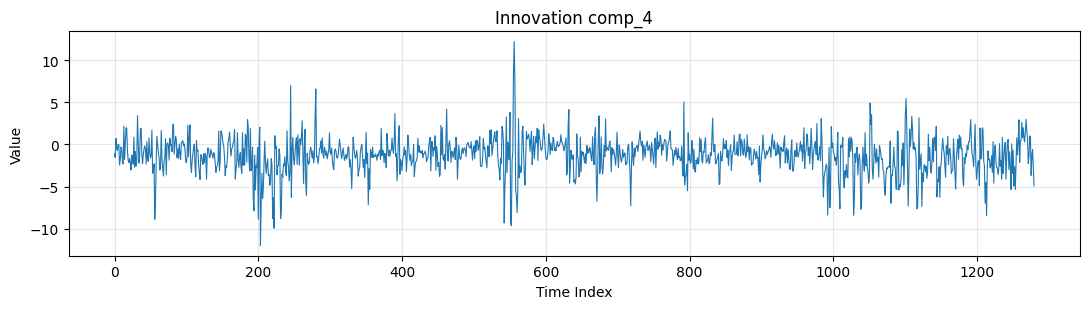

In [14]:
n_plot = 5  
n_plot = int(min(n_plot, innovations_hat.shape[1]))

print(f"Displaying the first {n_plot} innovation time series...")

# --- Plotting ---
for i in range(n_plot):
    plt.figure(figsize=(11, 3.2))
    
    plt.plot(innovations_hat[:, i], lw=0.8)
    
    plt.title(f"Innovation comp_{i}")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show() 